# VAE

In [1]:
import sys
import os
import seaborn as sns
sys.path.append( '..' )

from VAE.smac_runhistories import *
from VAE.vae import *

## Parameter definition

In [11]:
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/FIA/Com8_grown_together/oms"))
run_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/hyperparameter_optimization"))
results_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/VAE/results"))
verbosity = 1
backend_name = "tensorflow"
computation = "gpu"
outdir = Path(os.path.normpath(os.path.join(run_dir, f"smac_vae_{backend_name}_{computation}")))

time_step(message="Setup loaded", verbosity=verbosity)

X = read_data(data_dir, verbosity=verbosity)

Setup loaded (2907.9611887931824s)
Data loaded (1.3378102779388428s)


## Search interpretation

In [15]:
import ast
import scipy

In [4]:
results = pd.read_csv(os.path.join(results_dir, "results_hp_search.tsv"), sep="\t")
results

,Unnamed: 0,config_id,config,instance,budget,seed,loss,time,status,additional_info
0,0,1,"{'input_dropout': 0.2744067519636624, 'interme...",NaN,3.703704,209652396,4.287091,5.946154,1,{}
1,1,2,"{'input_dropout': 0.35759468318620974, 'interm...",NaN,3.703704,209652396,5.677361,3.575746,1,{}
2,2,3,"{'input_dropout': 0.30138168803582194, 'interm...",NaN,3.703704,209652396,1.626674,1.867249,1,{}
3,3,4,"{'input_dropout': 0.27244159149844843, 'interm...",NaN,3.703704,209652396,1.753383,3.445244,1,{}
4,4,5,"{'input_dropout': 0.21182739966945235, 'interm...",NaN,3.703704,209652396,8.027390,0.957173,1,{}
...,...,...,...,...,...,...,...,...,...,...
13105,13105,9191,"{'input_dropout': 0.06321367748265289, 'interm...",NaN,3.703704,209652396,3.021076,1.330938,1,{}
13106,13106,9180,"{'input_dropout': 0.13923965638943803, 'interm...",NaN,11.111111,209652396,0.926140,4.534626,1,{}
13107,13107,9183,"{'input_dropout': 0.26701624577176075, 'interm...",NaN,11.111111,209652396,0.030942,1.763532,1,{}
13108,13108,9169,"{'input_dropout': 0.08636796183064274, 'interm...",NaN,11.111111,209652396,1.189073,4.358716,1,{}


In [48]:
config_df = pd.DataFrame([ast.literal_eval(config) for config in results["config"].to_list()])
hyperparameters = ["input_dropout", "intermediate_dimension", "intermediate_layers", "latent_dimension", "learning_rate"]
plt_df = pd.concat([config_df[hyperparameters], results[["loss", "budget"]]], axis=1)

In [118]:
plt_df["true_layers"] = plt_df["intermediate_layers"]
for i in plt_df.index:
    for j in range(plt_df.loc[i, "intermediate_layers"]):
        if plt_df.loc[i, "intermediate_dimension"] // 2**j < plt_df.loc[i, "latent_dimension"]:
            plt_df.loc[i, "true_layers"]  = min(j, plt_df.loc[i, "intermediate_layers"])
            break
hyperparameters.remove("intermediated_layers")

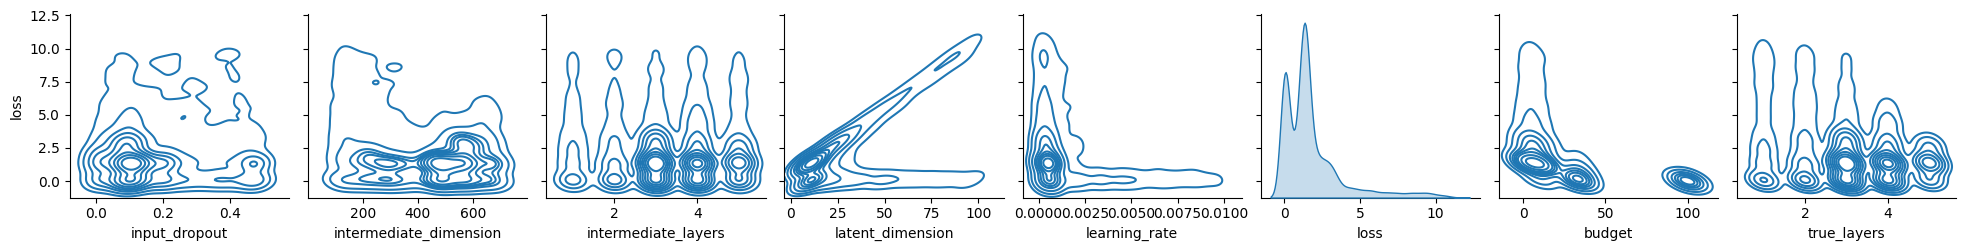

In [120]:
ax1 = sns.pairplot(plt_df,
             x_vars=hyperparameters + "true_layers",
             y_vars=['loss'],
             kind="kde")

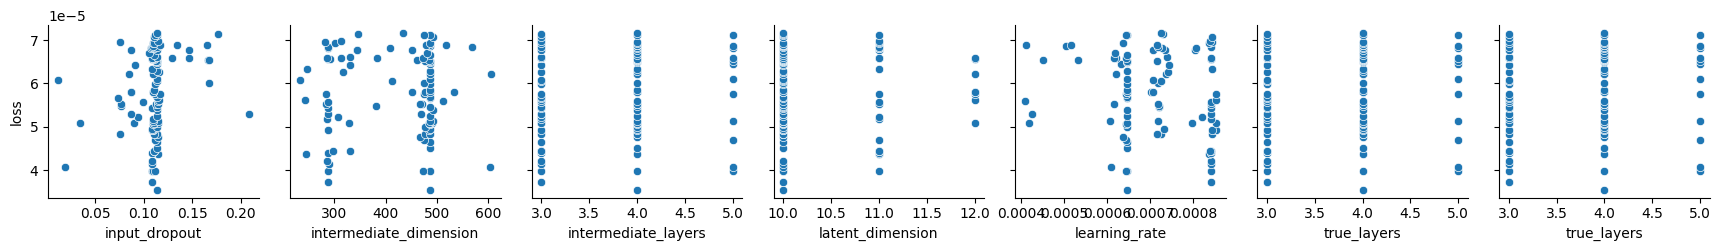

In [121]:
ax2 = sns.pairplot(plt_df.sort_values("loss", ascending=True)[0:100],
             x_vars=hyperparameters,
             y_vars=['loss'])

<Axes: xlabel='intermediate_activation', ylabel='loss'>

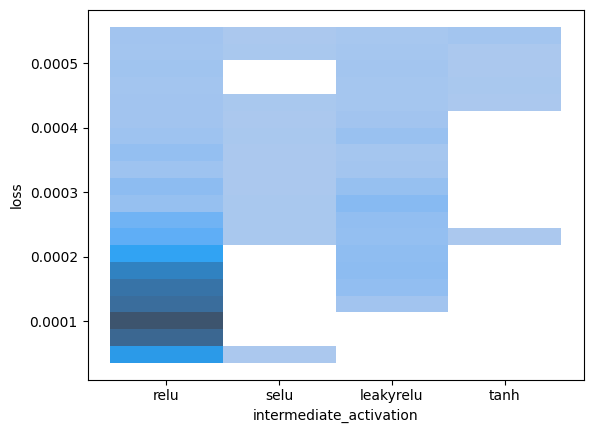

In [62]:
sns.histplot(plt_df.sort_values("loss", ascending=True)[0:1000], x="intermediate_activation", y="loss")

In [77]:
for hp in hyperparameters:
    corr = scipy.stats.spearmanr(plt_df[hp], 1-plt_df["loss"]).statistic
    print(f"Pearson correlation of {hp} and loss: {corr}")

Pearson correlation of input_dropout and loss: -0.11431856122384046
Pearson correlation of intermediate_dimension and loss: 0.15520304157725182
Pearson correlation of intermediate_layers and loss: 0.05988409220446543
Pearson correlation of latent_dimension and loss: -0.6258248691675299
Pearson correlation of learning_rate and loss: 0.11406141401488774
Pearson correlation of true_layers and loss: 0.02425535302042016


## Training

In [ ]:
# On cluster

In [ ]:
name = "1"
model = keras.saving.load_model(os.path.join(outdir, f"vae_{backend_name}_{computation}_{name}.keras"),
                                custom_objects=None, compile=True, safe_mode=True)
model.load_weights(os.path.join(outdir, f"vae_{backend_name}_{computation}_{name}.weights.h5"))

## Reconstruction

In [ ]:
reconstructed_data = model(X)

### Show model

In [40]:
keras.utils.model_to_dot(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=300,
    subgraph=True,
    show_layer_activations=True,
    show_trainable=True
)

## Plot training

In [4]:
history = pd.read_csv("/mnt/d/runs/VAE/training/vae_tensorflow_cpu_hm_1/vae_tensorflow_cpu_hm_1.history.tsv", sep="\t", index_col="Unnamed: 0")
history

,kl_loss,loss,reconstruction_loss,val_kl_loss,val_loss,val_reconstruction_loss
0,0.000000,0.005439,0.005439,0.020408,0.020434,0.000026
1,0.078654,0.078680,0.000026,0.012319,0.012320,0.000001
2,0.047462,0.047464,0.000001,0.005980,0.005982,0.000001
3,0.023067,0.023068,0.000001,0.002579,0.002581,0.000001
4,0.009951,0.009952,0.000001,0.001427,0.001428,0.000001
...,...,...,...,...,...,...
95,0.000000,0.000001,0.000001,0.000000,0.000001,0.000001
96,0.000000,0.000001,0.000001,0.000000,0.000001,0.000001
97,0.000000,0.000001,0.000001,0.000000,0.000001,0.000001
98,0.000000,0.000001,0.000001,0.000000,0.000001,0.000001


In [5]:
training_losses = history[[col for col in history.columns if not col.startswith("val")]]
validation_losses = history[[col for col in history.columns if col.startswith("val")]]

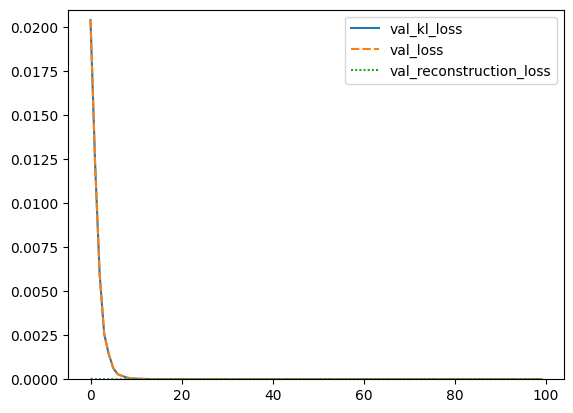

In [6]:
ax = sns.lineplot(validation_losses)
plt.ylim([-2e-6, 2.1e-2])
plt.show()

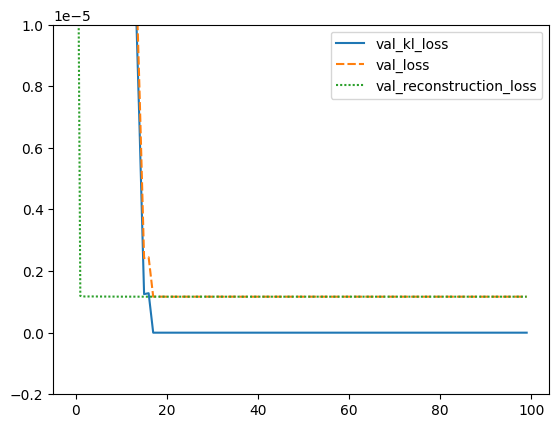

In [7]:
ax = sns.lineplot(validation_losses)
plt.ylim([-2e-6, 1e-5])
plt.show()

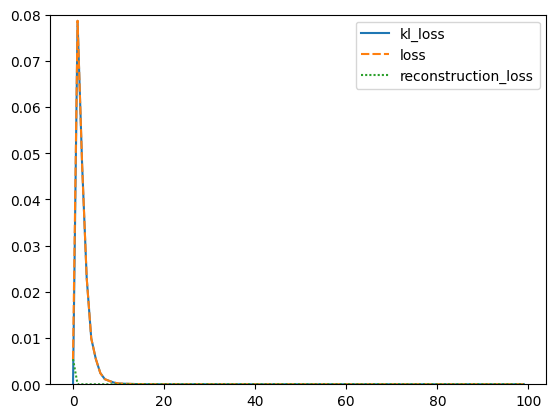

In [8]:
ax = sns.lineplot(training_losses)
plt.ylim([-2e-6, 8e-2])
plt.show()

## Plot results

In [13]:
reconstructed_data = pd.read_csv("/mnt/d/runs/VAE/training/vae_tensorflow_cpu_hm_1/vae_tensorflow_cpu_hm_1.prediction.tsv", index_col="Unnamed: 0")#, sep="\t")
reconstructed_data

,0,1,2,3,4,5,6,7,8,9,...,824990,824991,824992,824993,824994,824995,824996,824997,824998,824999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
plot_df = pd.DataFrame(reconstructed_data.loc[0].values, index=X.columns, columns=["inty"]).reset_index()
plot_df_2 = pd.DataFrame(X.iloc[0].values, index=X.columns, columns=["inty"]).reset_index()

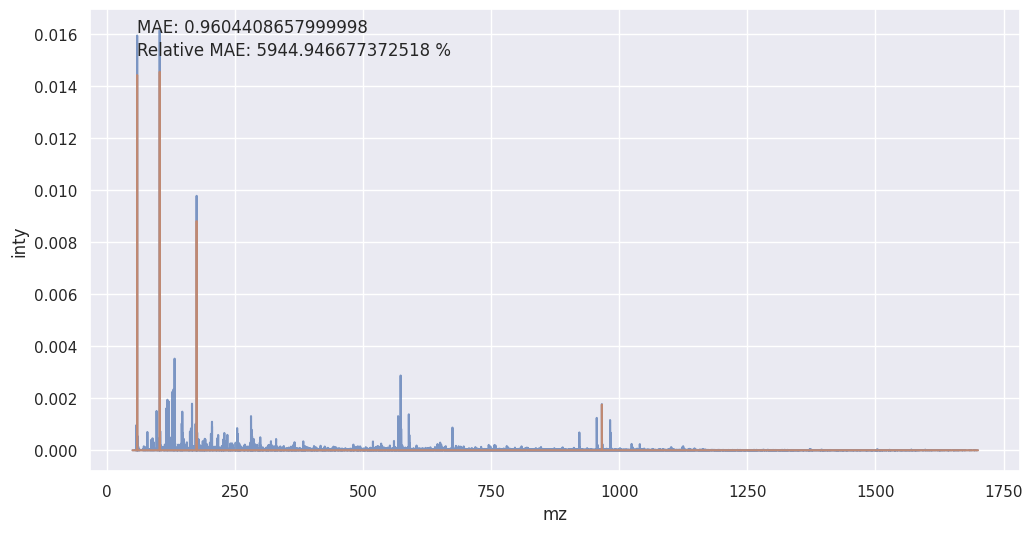

In [21]:
mae = np.mean(np.sum( np.abs((plot_df_2["inty"] - plot_df["inty"])) ))
rel_mae = mae / np.max(plot_df_2["inty"])

sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
plt.annotate(f"MAE: {mae}", xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(f"Relative MAE: {rel_mae *100} %", xy=(0.05, 0.90), xycoords='axes fraction')
plt.show()

(965.9, 966.1)

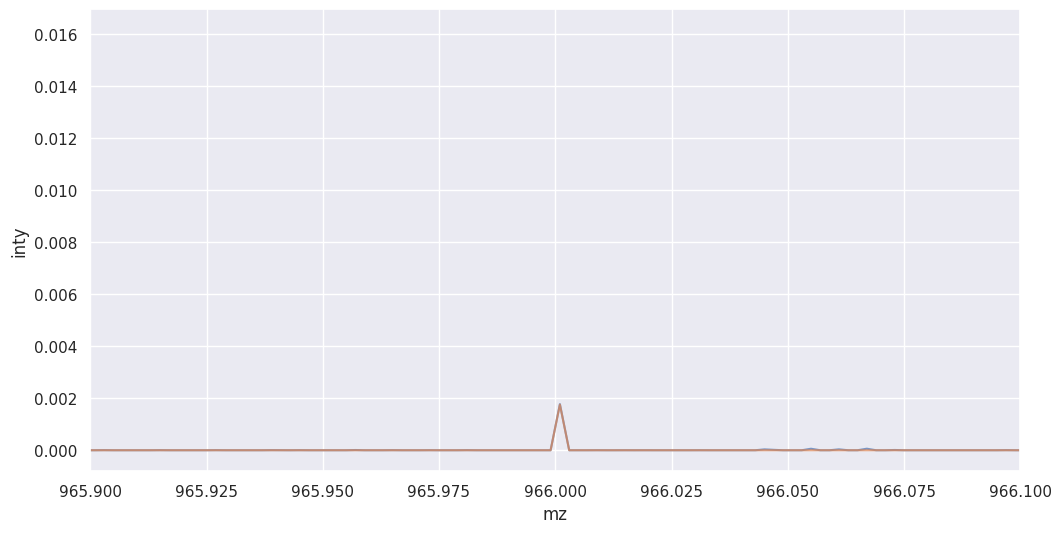

In [39]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(965.9, 966.1)

(-0.0001, 0.003)

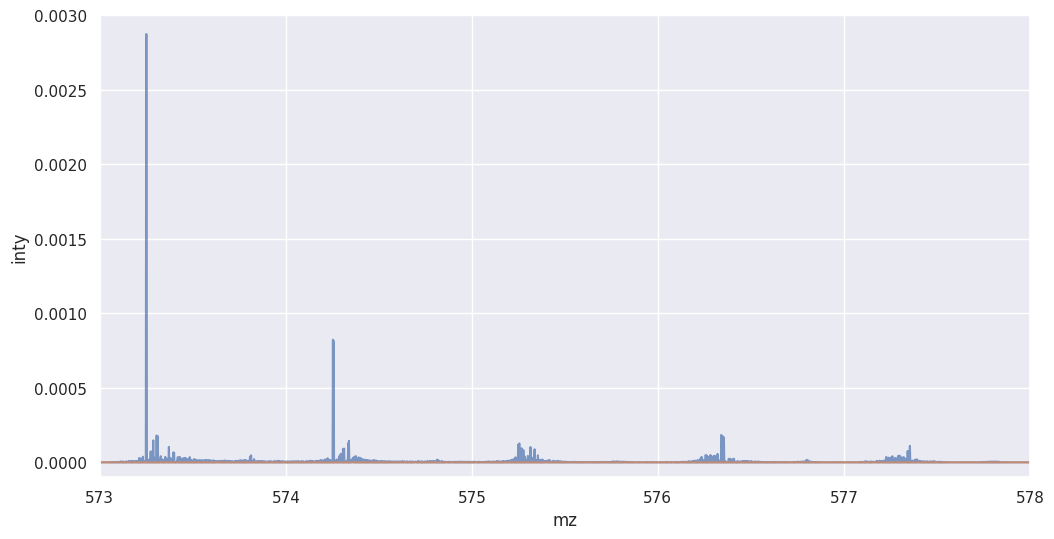

In [16]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573, 578)
ax.set_ylim(-0.0001, 0.003)

(-0.0001, 0.0022)

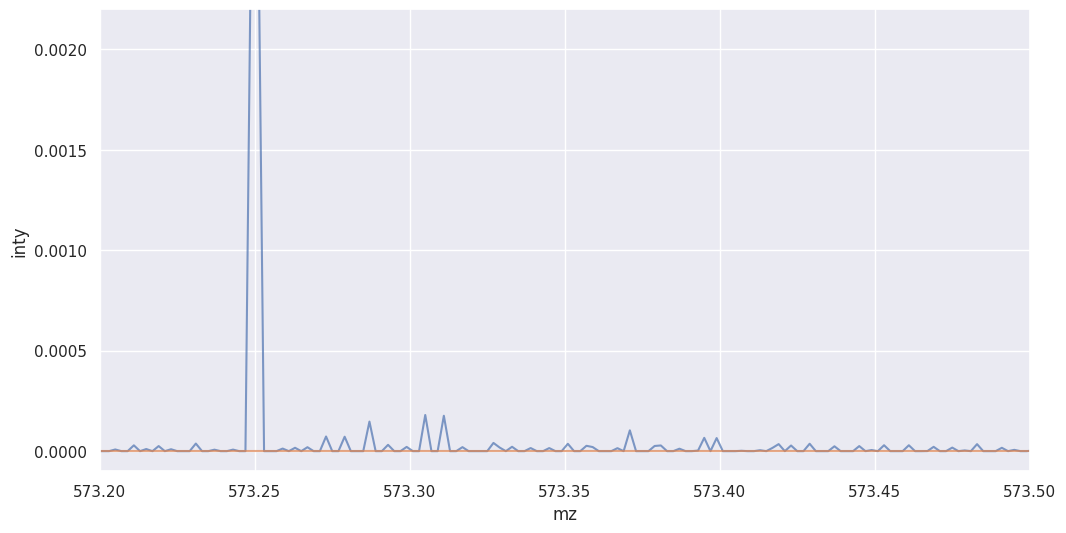

In [17]:
sns.set_theme(rc={"figure.figsize":(12, 6)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573.2, 573.5)
ax.set_ylim(-0.0001, 0.0022)

## Classification

In [ ]:
# Load matrices
strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")

In [ ]:
vae_enc = mtmodel.encode_mu(X)
vae_enc = pd.DataFrame(vae_enc)
vae_enc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.040587,-0.184386,0.186828,0.178457,0.104944,0.323250,0.001226,0.100432,0.167224,-0.362768,-0.029526,0.175242,0.076567,-0.166418,0.162517,-0.237154,-0.054643,0.212377,-0.114535,-0.008502
1,-0.042219,-0.186205,0.186309,0.179352,0.103276,0.323463,0.000774,0.100708,0.167397,-0.362725,-0.029135,0.174520,0.076391,-0.167263,0.162701,-0.236665,-0.054667,0.213280,-0.113130,-0.008329
2,-0.039721,-0.182793,0.183115,0.177548,0.101912,0.317924,-0.000246,0.100371,0.164644,-0.357129,-0.030553,0.174054,0.077742,-0.162382,0.162453,-0.234839,-0.053447,0.209512,-0.113043,-0.007733
3,-0.041061,-0.185449,0.187599,0.178005,0.105359,0.324202,0.001432,0.099781,0.168674,-0.364253,-0.029961,0.175288,0.076527,-0.165382,0.162212,-0.238606,-0.054351,0.211943,-0.114262,-0.010218
4,-0.040675,-0.183967,0.186178,0.177980,0.104538,0.322031,0.001237,0.100191,0.166761,-0.361580,-0.029428,0.174614,0.076446,-0.165869,0.162073,-0.236529,-0.054455,0.211660,-0.114074,-0.008538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-0.041592,-0.186487,0.189693,0.179270,0.103745,0.324505,0.003021,0.100621,0.167529,-0.364951,-0.029451,0.176775,0.076843,-0.168174,0.161341,-0.237823,-0.054451,0.213257,-0.114875,-0.008866
64,-0.043291,-0.186846,0.186274,0.176963,0.105697,0.325417,0.001617,0.098610,0.169118,-0.362662,-0.029590,0.175303,0.075180,-0.164818,0.162999,-0.238674,-0.055341,0.209760,-0.112030,-0.008592
65,-0.040760,-0.183984,0.186283,0.177985,0.104601,0.322057,0.001358,0.100242,0.166779,-0.361683,-0.029522,0.174648,0.076484,-0.165901,0.161995,-0.236490,-0.054428,0.211720,-0.114052,-0.008544
66,-0.039782,-0.181248,0.187935,0.175375,0.106807,0.320874,-0.000416,0.098744,0.166897,-0.364459,-0.030205,0.175222,0.077733,-0.163980,0.160756,-0.238355,-0.055411,0.213546,-0.118463,-0.010409


In [ ]:
from sklearn.model_selection import KFold
X = vae_enc
ys = comm8
cv = 5
kf = KFold(n_splits = cv, shuffle=True)

In [ ]:
def build_model(hyperparameters):
    model = keras.Sequential(name="MS_community_classifier")
    model.add(layers.InputLayer(input_shape=(X.shape[1],)))
    if hyperparameters.Boolean("dropout_in"):
        model.add(keras.layers.Dropout(0.5, noise_shape=None, seed=None))
    model.add(keras.layers.BatchNormalization())
    
    for i in range(hyperparameters.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hyperparameters.Int(f"units_{i}", min_value=32, max_value=256, step=64),
                activation=hyperparameters.Choice("activation", ["relu", "tanh"]),
            )
        )    
    if hyperparameters.Boolean("dropout"):
        model.add(keras.layers.Dropout(0.25, noise_shape=None, seed=None))
    model.add(keras.layers.BatchNormalization())

    model.add(layers.Dense(1,  activation=activations.sigmoid))
    
    loss_function = keras.losses.BinaryCrossentropy()

    learning_rate = hyperparameters.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = keras.optimizers.legacy.Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    return model

In [ ]:
hp = keras_tuner.HyperParameters()
hp.Fixed("dropout", True)
hp.Fixed("num_layers", 1)
hp.Fixed("units_1", 64)
hp.Fixed("activation", "relu")
hp.Fixed("lr", 1e-3)

In [ ]:
confusion_matrices = []
accuracies = []

for y in tqdm(ys.columns):
	y = ys[y]
	conf_mats = []
	acc = []
	for train_index, val_index in kf.split(X, y):
		class_model = build_model(hp)
		training_data = X.iloc[train_index]
		training_labels = y.iloc[train_index]
		validation_data = X.iloc[val_index]
		validation_labels = y.iloc[val_index]
		
		callback = keras.callbacks.EarlyStopping(monitor='loss', patience=100)	# Model will stop when no improvment is reached after 1000 epochs
		history = class_model.fit(training_data, training_labels, epochs=1000, verbose=0, callbacks=[callback])

		val_loss, val_acc = class_model.evaluate(validation_data,  validation_labels, verbose="auto")
		acc.append(val_acc)
		prediction = class_model.predict(validation_data)
		prediction = [0.0 if pred[0] < 0.5 else 1.0 for pred in prediction]
		conf_mats.append(confusion_matrix(validation_labels,  prediction))

	accuracies.append(acc)
	confusion_matrices.append(np.sum(conf_mats, axis=0))

  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.

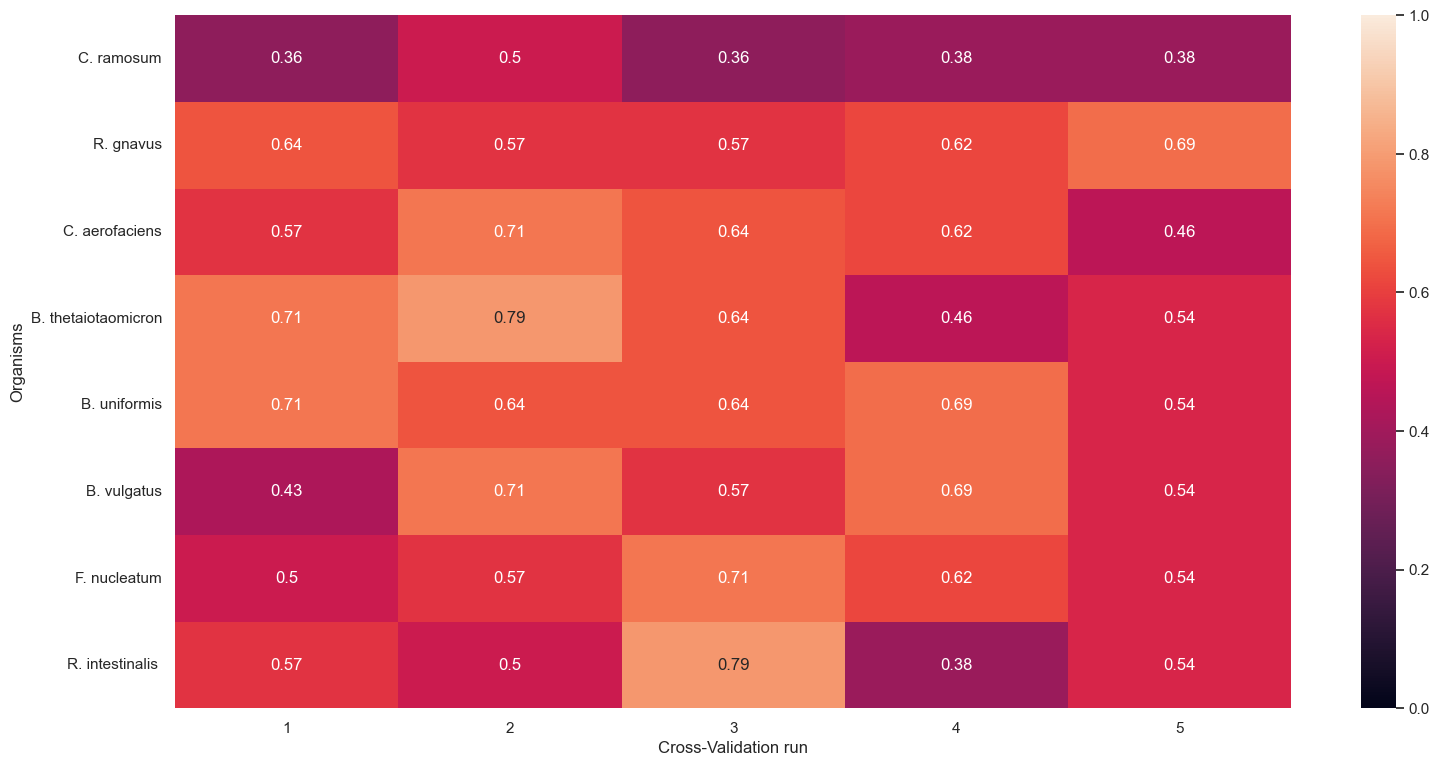

In [ ]:
# Accuracy CV matrix
plot_df = pd.DataFrame(accuracies, columns=range(1,cv+1), index=strains["0"])
plot_df.index.name = "Organisms"
plot_df.columns.name = "Cross-Validation run"
ax = sns.heatmap(plot_df, vmin=0, vmax=1.0, annot=True)

In [ ]:
plot_cv_confmat(ys=ys, target_labels=strains.values, accuracies=np.mean(accuracies, axis=1), confusion_matrices=confusion_matrices,
				outdir="../../runs/ML/try/NN", name="VAE-64(0.5)ReLU-LR0.001,1000epochs.png")